'''
A Reccurent Neural Network (LSTM) implementation example using TensorFlow library.
This example is using the MNIST database of handwritten digits (http://yann.lecun.com/exdb/mnist/)
Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

In [1]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# for plotting graphs:
import matplotlib.pyplot as plt
%matplotlib inline

# Import the os module:
import os

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


'''
To classify images using a reccurent neural network, we consider every image
row as a sequence of pixels. Because MNIST image shape is 28*28px, we will then
handle 28 sequences of 28 steps for every sample.
'''

In [2]:
# Important paths:
base_models_path = "Models"
log_dir = os.path.join(base_models_path, "RNN", "logdir")

model_name = "Model1"

In [3]:
# Parameters
learning_rate = 0.001
training_iters = 100000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 28 # MNIST data input (img shape: 28*28)
n_steps = 28 # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = 10 # MNIST total classes (0-9 digits)

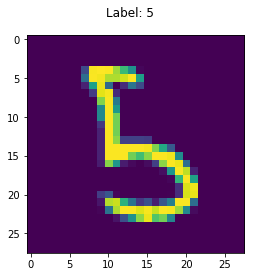

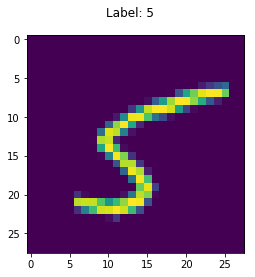

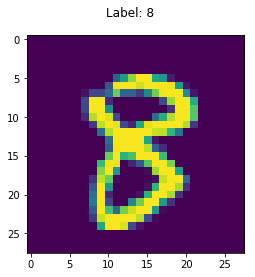

In [4]:
# view a few random images from the dataset
images = mnist.train.images.reshape(-1, n_input, n_steps)
labels = mnist.train.labels

# we display 3 random images from this sample
for _ in range(3):
    random_index = np.random.randint(images.shape[0])
    random_image = images[random_index]; label = np.where(labels[random_index] == 1)[0][0]
    
    # plot the image:
    plt.figure().suptitle("Label: " + str(label))
    plt.imshow(random_image)

### Run the above cell a few times to see different results.

In [7]:
RNN_GRAPH = tf.Graph()

with RNN_GRAPH.as_default():
    
    # tf Graph input
    x = tf.placeholder("float", [None, n_steps, n_input], name="Input_data")
    y = tf.placeholder("float", [None, n_classes], name="Input_labels")

    # Define weights
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    
    def RNN(x, weights, biases):

        # Prepare data shape to match `rnn` function requirements
        # Current data input shape: (batch_size, n_steps, n_input)
        # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

        # Permuting batch_size and n_steps
        x = tf.transpose(x, [1, 0, 2])
        # Reshaping to (n_steps*batch_size, n_input)
        x = tf.reshape(x, [-1, n_input])
        # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
        x = tf.split(x, n_steps, 0)

        # Define a lstm cell with tensorflow
        lstm_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)

        # Get lstm cell output
        outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

        # Linear activation, using rnn inner loop last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']

    pred = RNN(x, weights, biases)

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

    # summary for visualizing the cost 
    cost_summary = tf.summary.scalar("Loss", cost)

    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # summary for accuracy
    accuracy_summary = tf.summary.scalar("Accuracy", accuracy)

    # merged summary:
    all_summaries = tf.summary.merge_all()

In [10]:
# Launch the graph
with tf.Session(graph=RNN_GRAPH) as sess:
    # create the writer object for this session
    log_path = os.path.join(log_dir, model_name)
    tensorboard_writer = tf.summary.FileWriter(log_path, graph=sess.graph)
    
    sess.run(tf.global_variables_initializer())
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Reshape data to get 28 seq of 28 elements
        batch_x = batch_x.reshape((batch_size, n_steps, n_input))
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        if step % display_step == 0:
            # Calculate batch accuracy
            acc, loss, summ = sess.run([accuracy, cost, all_summaries], feed_dict={x: batch_x, y: batch_y})
            
            # record the summaries:
            tensorboard_writer.add_summary(summ, step)
            
            print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc)
        step += 1
    print "Optimization Finished!"

    # Calculate accuracy for 128 mnist test images
    test_len = 128
    test_data = mnist.test.images[:test_len].reshape((-1, n_steps, n_input))
    test_label = mnist.test.labels[:test_len]
    print "Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: test_data, y: test_label})

Iter 1280, Minibatch Loss= 1.869755, Training Accuracy= 0.38281
Iter 2560, Minibatch Loss= 1.398164, Training Accuracy= 0.52344
Iter 3840, Minibatch Loss= 1.290797, Training Accuracy= 0.59375
Iter 5120, Minibatch Loss= 0.938388, Training Accuracy= 0.65625
Iter 6400, Minibatch Loss= 1.046592, Training Accuracy= 0.71094
Iter 7680, Minibatch Loss= 0.808783, Training Accuracy= 0.75000
Iter 8960, Minibatch Loss= 0.654342, Training Accuracy= 0.78906
Iter 10240, Minibatch Loss= 0.519232, Training Accuracy= 0.82031
Iter 11520, Minibatch Loss= 0.412831, Training Accuracy= 0.85156
Iter 12800, Minibatch Loss= 0.354895, Training Accuracy= 0.89062
Iter 14080, Minibatch Loss= 0.278876, Training Accuracy= 0.89844
Iter 15360, Minibatch Loss= 0.473290, Training Accuracy= 0.83594
Iter 16640, Minibatch Loss= 0.364607, Training Accuracy= 0.87500
Iter 17920, Minibatch Loss= 0.452570, Training Accuracy= 0.88281
Iter 19200, Minibatch Loss= 0.187583, Training Accuracy= 0.96094
Iter 20480, Minibatch Loss= 0.23

# To visualize the Above RNN in tensorboard, run the following command:
-------------------------------------------------------------------------------------------------------------------

## $: tensorboard --logdir=[path to the logdir]